# Para este analisis solo se toma 55000 lineas del total del dataset, 50 pozos.

In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
train=pd.read_csv("CAX_LogFacies_Train_File.csv")
#test=pd.read_csv("CAX_LogFacies_Test_File.csv")

In [25]:
len(set(list(train["well_id"])))

4000

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   row_id   55000 non-null  int64  
 1   well_id  55000 non-null  int64  
 2   GR       55000 non-null  float64
 3   label    55000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.7 MB


In [3]:
train.describe()

,row_id,well_id,GR,label
count,55000.000000,55000.000000,55000.000000,55000.000000
mean,549.500000,24.500000,109.059096,1.225073
std,317.545404,14.431001,33.901931,1.494554
min,0.000000,0.000000,4.804632,0.000000
25%,274.750000,12.000000,82.994217,0.000000
50%,549.500000,24.500000,120.046479,0.000000
75%,824.250000,37.000000,134.037614,3.000000
max,1099.000000,49.000000,187.631401,4.000000


## Gráfico ejemplo de lo que se encuentra en un pozo del dataset. Se ve que la clase 0 (azul) es la clase mayoritaria que presenta menor tendencia que las otras
## En negro sobre el eje derecho se ve el numero de label de cada clase

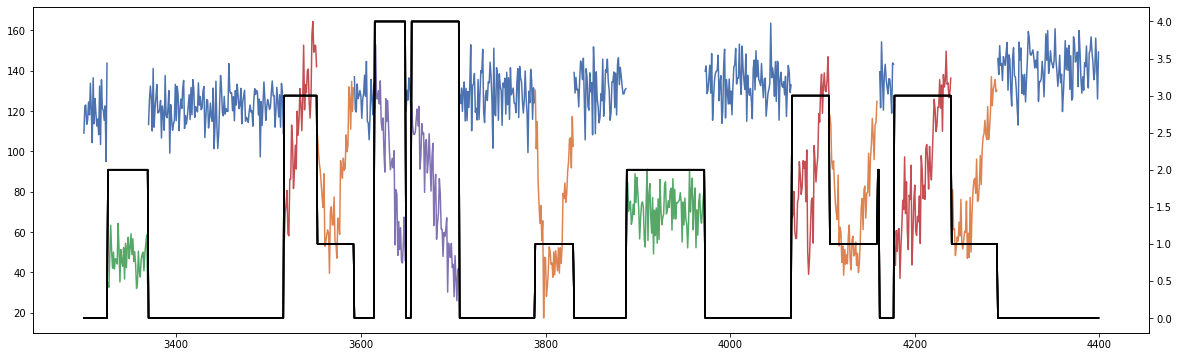

In [9]:
def plot_multicolored_line(df, i):
    df = train.query("well_id == '{}'".format(i))
    labels= df["label"].unique()
    palette = sns.color_palette('deep', len(labels))gh
    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copydf = df.copy()
        copydf.loc[copydf['label']!= l, "GR"] = np.nan
        axes1.plot(copydf["GR"], color=palette[l])
        #copydf.loc[copydf['label']!= l, "label"] = np.nan
        axes2.plot(copydf["label"], color="k")

plot_multicolored_line(train ,3)



## Distribucion de las labels en los 50 pozos

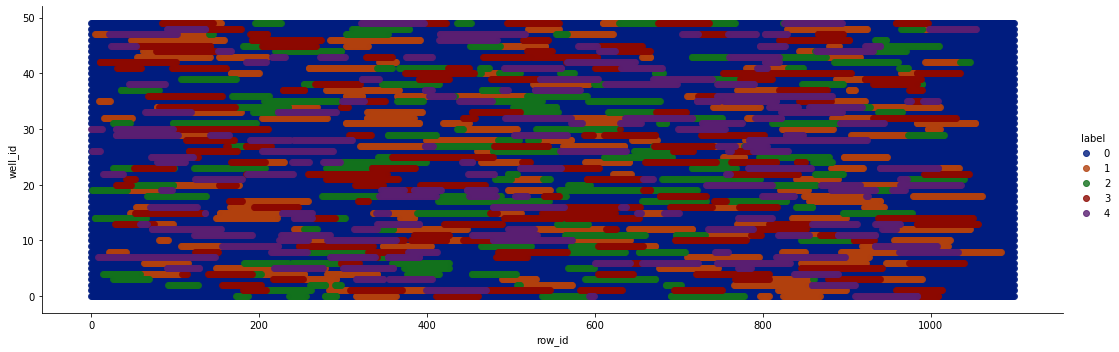

In [18]:
sns.lmplot( x="row_id", y="well_id", data=train, fit_reg=False, hue='label',palette='dark', legend=True, height=5, aspect=3)

## Distribucion total de las clases

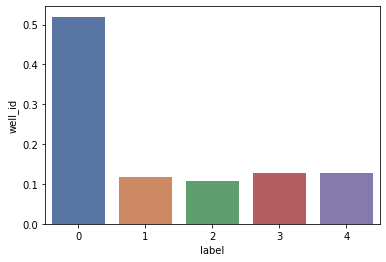

In [5]:
data = (train.groupby(['label']).count()/train.count())[["well_id"]]
sns.barplot(x=data.index,y='well_id', data=data, palette='deep')

## Distribucion cada clase a lo largo de la profundidad del pozo
## Vemos que en los extremos hay principalmente labels 0

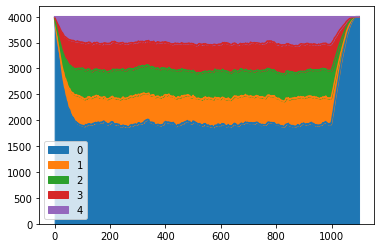

In [45]:
pivoted = pd.pivot_table(data = train,columns  = "well_id",aggfunc='mean' ,index = 'row_id',values = "label")
df=pd.DataFrame()
for i in range(5):
    df=df.append(pivoted[pivoted == i].count(axis=1),ignore_index =True)
df = df.transpose()
df.plot(kind="area")

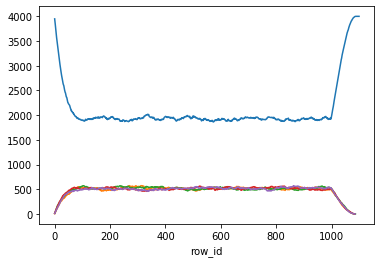

In [43]:
pivoted = pd.pivot_table(data = train.query("label == 0"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
pivoted.count(axis=1).plot()
pivoted = pd.pivot_table(data = train.query("label == 1"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
pivoted.count(axis=1).plot()
pivoted = pd.pivot_table(data = train.query("label == 2"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
pivoted.count(axis=1).plot()
pivoted = pd.pivot_table(data = train.query("label == 3"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
pivoted.count(axis=1).plot()
pivoted = pd.pivot_table(data = train.query("label == 4"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
pivoted.count(axis=1).plot()

## Distribucion de clases por pozo. Vemos que la clase mayoritaria es un 50% en casi todos los pozos y la distribucion de las demas es casi la misma

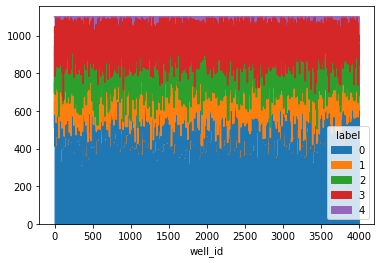

In [46]:
pivoted = pd.pivot_table(data = train,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR")
pivoted.plot(kind = 'area')


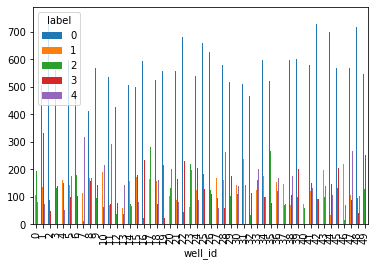

In [23]:
pd.pivot_table(data = train,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR").plot.bar()

## Feature Engineering
## Se propuso Normalizar y Standarizar la unica feature GR
## Se calculo tambien 3 ventanas de medias utilizando GR normalizados y el GR Standarizado tomando ventanas de 5, 10 y 15. Tambien se calculo la ventana de variacion de 10 de rango. 

In [24]:
train['GR_znorm']=train.groupby('well_id')['GR'].transform(lambda x: (x - x.mean()) / x.std())
train['GR_mnorm']=train.groupby('well_id')['GR'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
train['rolling_mean'] = train.groupby('well_id')['GR_mnorm'].rolling(5,win_type = "parzen",min_periods=1,center= True).mean().reset_index(0,drop=True)
train['rolling_mean2'] = train.groupby('well_id')['GR_mnorm'].rolling(10,win_type = "parzen ",min_periods=2,center= True).mean().reset_index(0,drop=True)
train['rolling_mean3'] = train.groupby('well_id')['GR_mnorm'].rolling(15,win_type = "parzen ",min_periods=3,center= True).mean().reset_index(0,drop=True)

train['rolling_std'] = train.groupby('well_id')['GR_mnorm'].rolling(10,min_periods=1,center= True).std().reset_index(0,drop=True)

train['n_rolling_mean'] = train.groupby('well_id')['GR_znorm'].rolling(5,win_type = "parzen",min_periods=1,center= True).mean().reset_index(0,drop=True)
train['n_rolling_mean2'] = train.groupby('well_id')['GR_znorm'].rolling(10,win_type = "parzen ",min_periods=2,center= True).mean().reset_index(0,drop=True)
train['n_rolling_mean3'] = train.groupby('well_id')['GR_znorm'].rolling(15,win_type = "parzen ",min_periods=3,center= True).mean().reset_index(0,drop=True)

train['n_rolling_std'] = train.groupby('well_id')['GR_znorm'].rolling(10,min_periods=1,center= True).std().reset_index(0,drop=True)

train["log_row_id"] = np.log(train["row_id"])

C:\Users\rodri\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Se grafico el pozo 22 junto con el suavizado de medias de ventana 5 y la ventana de variacion

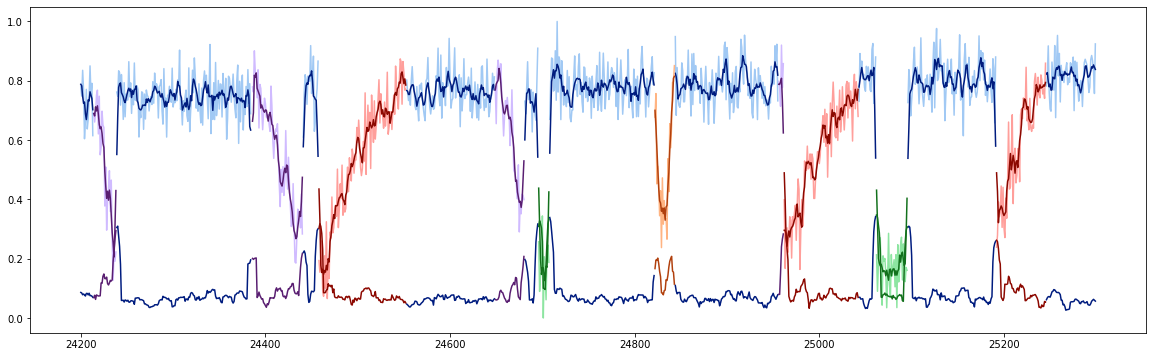

In [25]:
def plot_multicolored_line(df, i):
    df = train.query("well_id  in '{}'".format(i))
    labels= df["label"].unique()
    palette1 = sns.color_palette('dark', len(labels))
    palette2 = sns.color_palette('pastel', len(labels))
    plt.figure(figsize=(20, 6))
    for l in list(labels):
        copy = df.copy()
        copy.loc[copy['label']!= l,[ "GR_mnorm","rolling_std","rolling_mean" ]] = np.nan
        plt.plot(copy["GR_mnorm"], color=palette2[l])
        plt.plot(copy["rolling_std"], color=palette1[l]) 
        plt.plot(copy["rolling_mean"], color=palette1[l]) 
       # plt.plot(copy["rolling_mean2"], color="k") 

plot_multicolored_line(train ,22)


In [26]:
def transform(df,k,GR):
    for i in range(1,k):
        df["-"+GR+str(i)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(i))
        df["+"+GR+str(i)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(-i))
    df=df.fillna(0)
    return df

## Se agrego el valor de los siguientes 10 valores para atras y para adelante de cada punto para las ventanas de medias y ventana de variacion

In [27]:
train=transform(train,10,"rolling_mean2")
train=transform(train,10,"n_rolling_mean2")
train=transform(train,10,"rolling_std")
train=transform(train,10,"n_rolling_mean3")


In [28]:
train.replace([np.inf, -np.inf], np.nan, inplace = True)
train.fillna(0 , inplace = True)

## Division 40 pozos enteros para train y 10 pozos para test.

In [29]:
#test.drop(["unique_id","well_id"],axis=1,inplace=True)
#train.drop(["_id"],axis=1,inplace=True,errors ="ignore")
y=train["label"]
x=train.drop("label",axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle = False )

## Planteo de modelo geneerico de random forest. Falta optimizar hiperparametros mediante crossvalidation o similar

In [30]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=150, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=644,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=644,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Score evaluado sobre el mismo training 0.990341

In [31]:
predictions = model.predict(x_test)
model.score(x_train, y_train)

0.9903409090909091

In [32]:

test = x_test.copy()
test["predictions"] = predictions
test.loc[test["predictions"]== 1, "predictions"] = 2
test["label"] = y_test
test.loc[test["predictions"]>0,"predictionsuni"] = 2
test.loc[test["label"]>0,"labeluni"] = 1

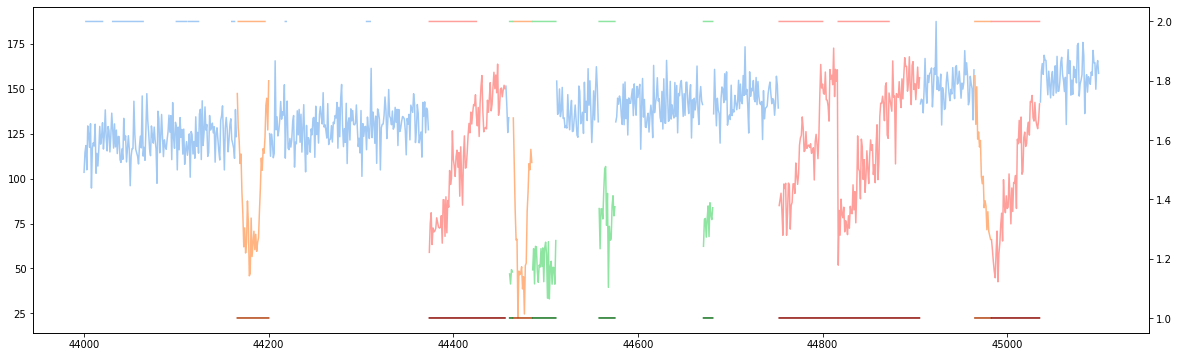

In [33]:
def plot_multicolored_line(df, i):
    df = df.query("well_id == '{}'".format(i))
    labels= df["label"].unique()
    palette1 = sns.color_palette('pastel', len(labels))
    palette2 = sns.color_palette('dark', len(labels))

    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copydf = df.copy()
        copydf.loc[copydf['label']!= l, ["GR","labeluni","predictionsuni"]] = np.nan
        axes1.plot(copydf["GR"], color=palette1[l])
        axes2.plot(copydf["predictionsuni"], color=palette1[l])
        axes2.plot(copydf["labeluni"], color=palette2[l])
plot_multicolored_line(test ,40)


In [34]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
model.score(x_test, y_test)

[[5943   35    1   67  132]
 [  73  600  112  179  114]
 [   0  289  575   28   29]
 [ 297  175   62 1033   66]
 [ 162   98   54   33  843]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6178
           1       0.50      0.56      0.53      1078
           2       0.72      0.62      0.67       921
           3       0.77      0.63      0.69      1633
           4       0.71      0.71      0.71      1190

    accuracy                           0.82     11000
   macro avg       0.72      0.70      0.71     11000
weighted avg       0.82      0.82      0.82     11000



0.8176363636363636

## Score evaluado sobre los 10 pozos de testing. 0.81763

In [35]:
model.score(x_test, y_test)


0.8176363636363636

## Importancia de las variables junto con su variacion en el random forest:

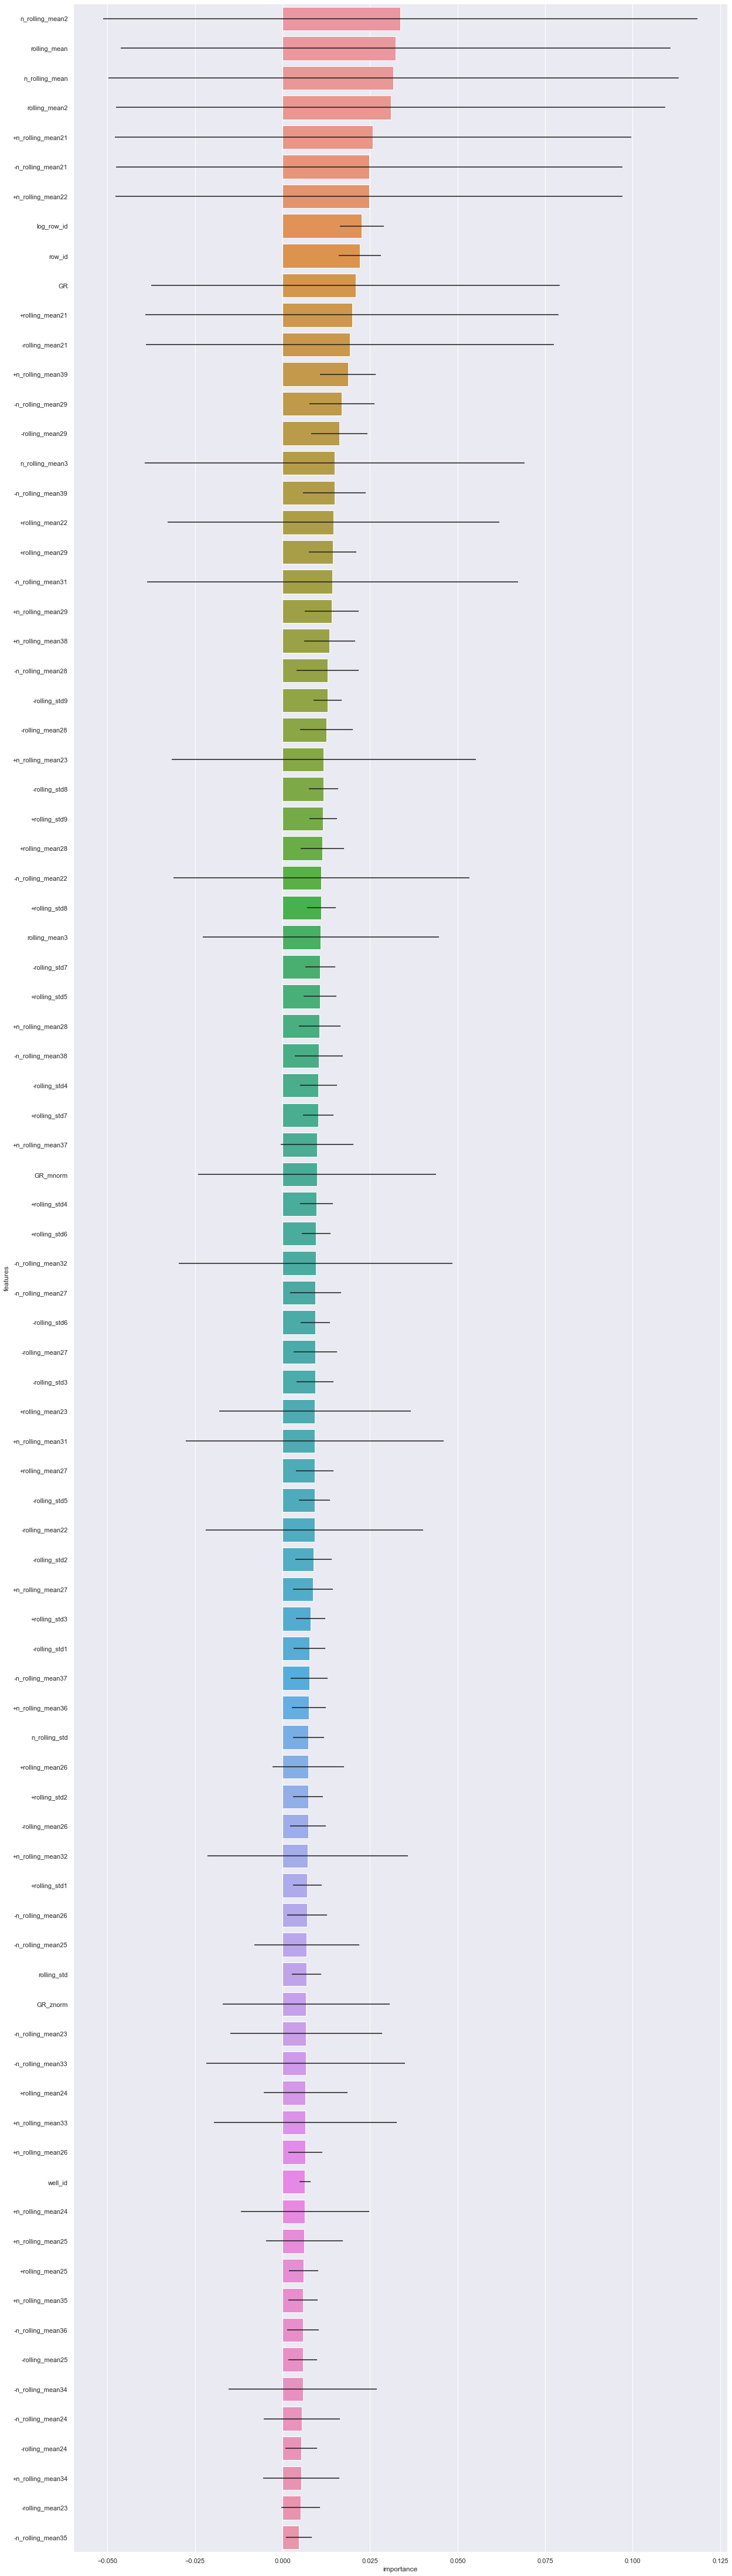

In [36]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,80)})
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
importance = model.feature_importances_
features = x_train.columns

feature_importance = pd.DataFrame()
feature_importance["importance"] = importance
feature_importance["std"] = std
feature_importance["features"] = features
feature_importance.sort_values("importance",ascending=False, inplace=True)
feature_importance.reset_index(drop = True , inplace = True)
sns.barplot(data =feature_importance , x ="importance", y ="features",xerr=feature_importance["std"])

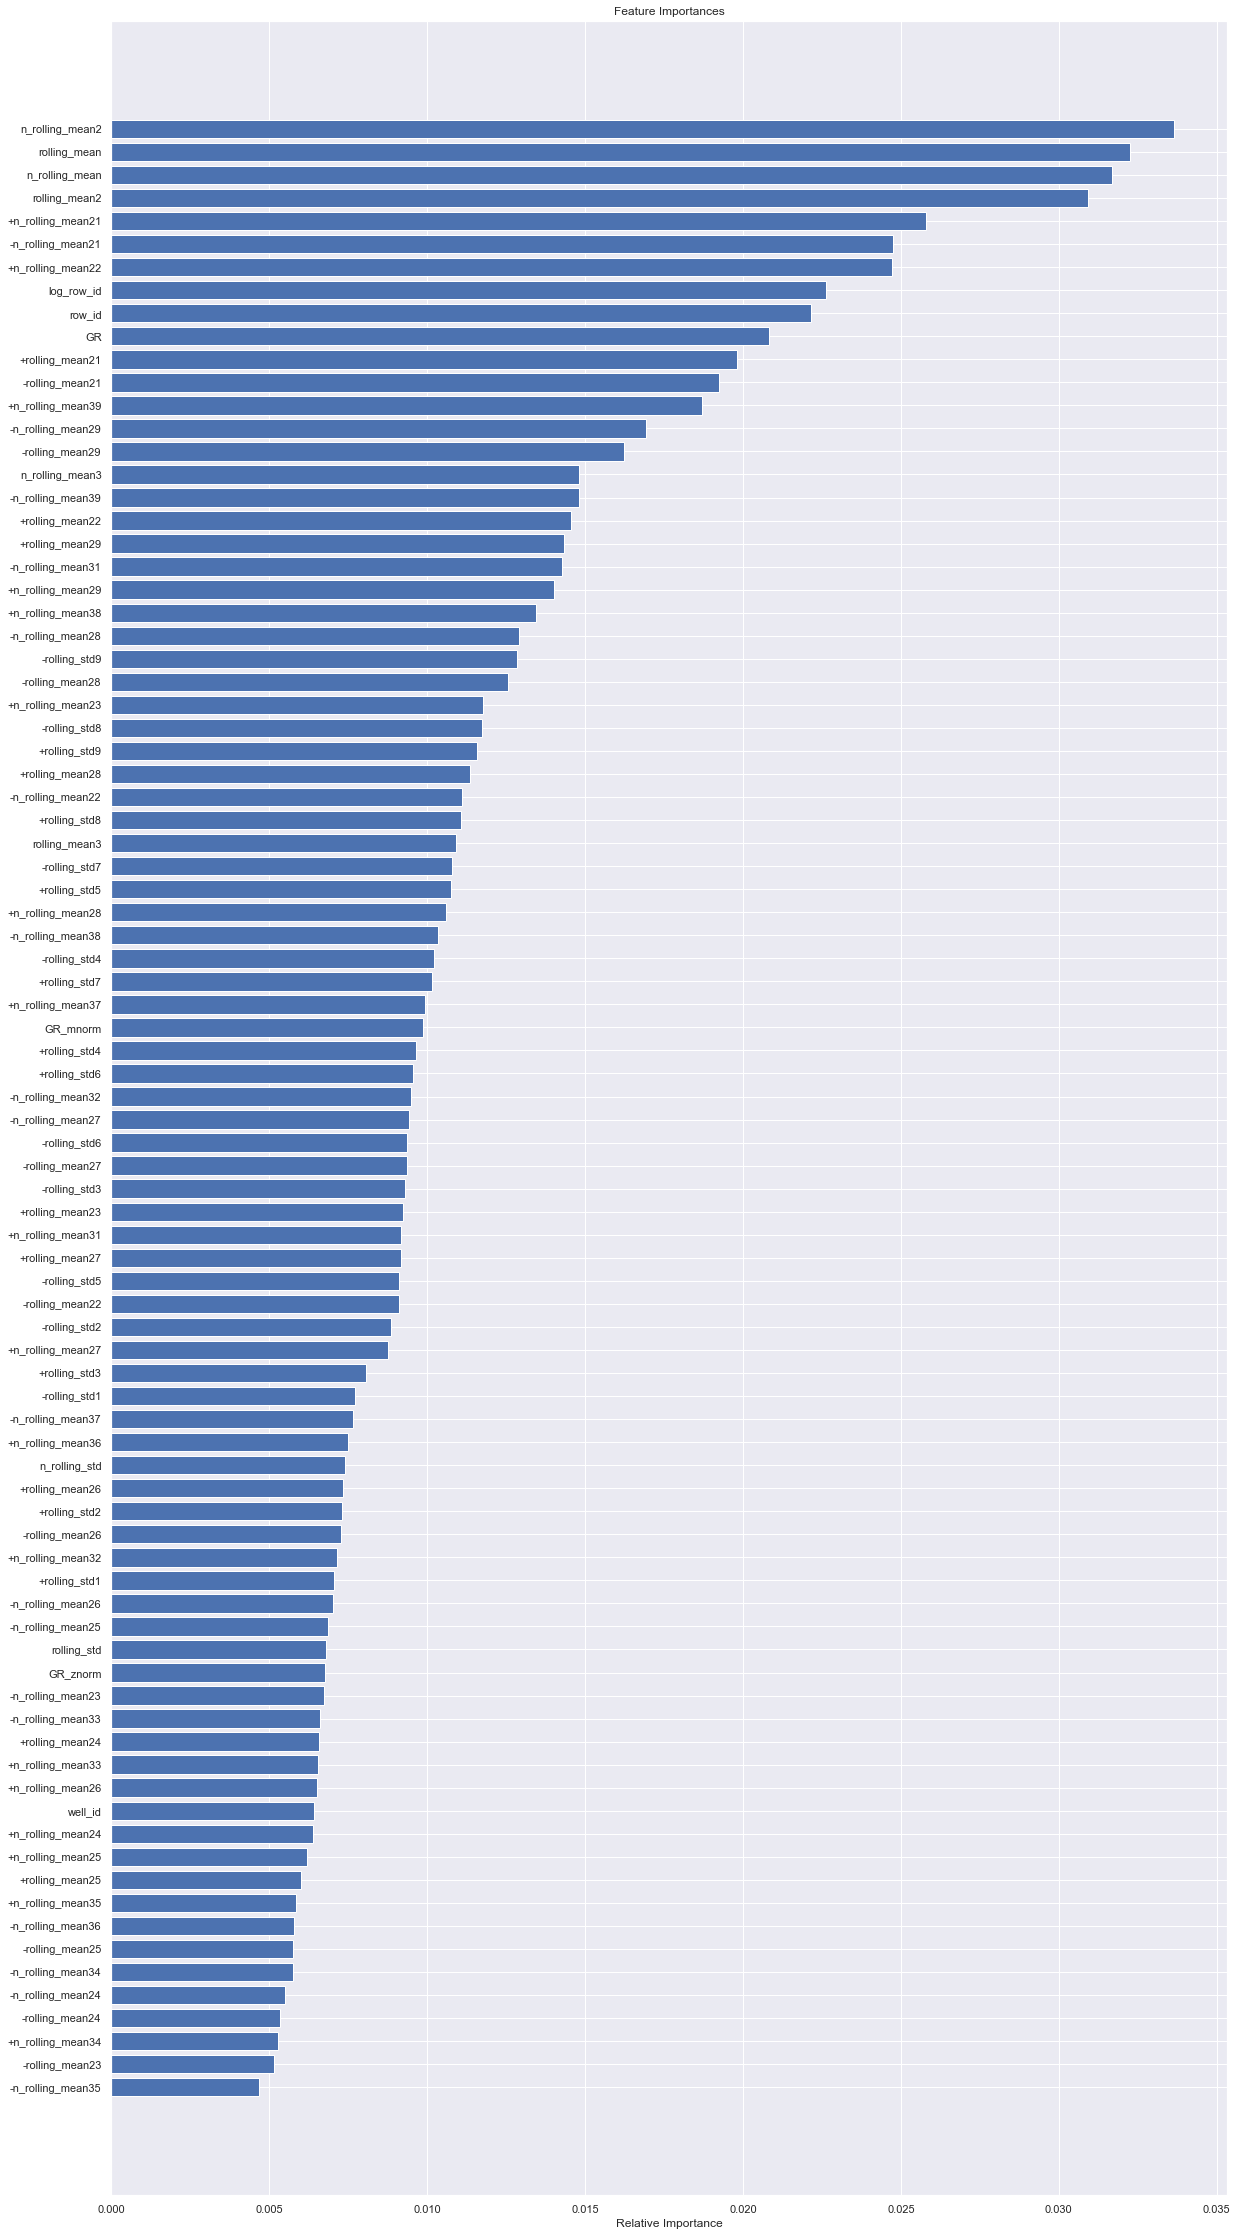

In [37]:
features = x_test.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(111)
plt.title('Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Planteo de Random foresto optimizacion no utilizado

Feature ranking:


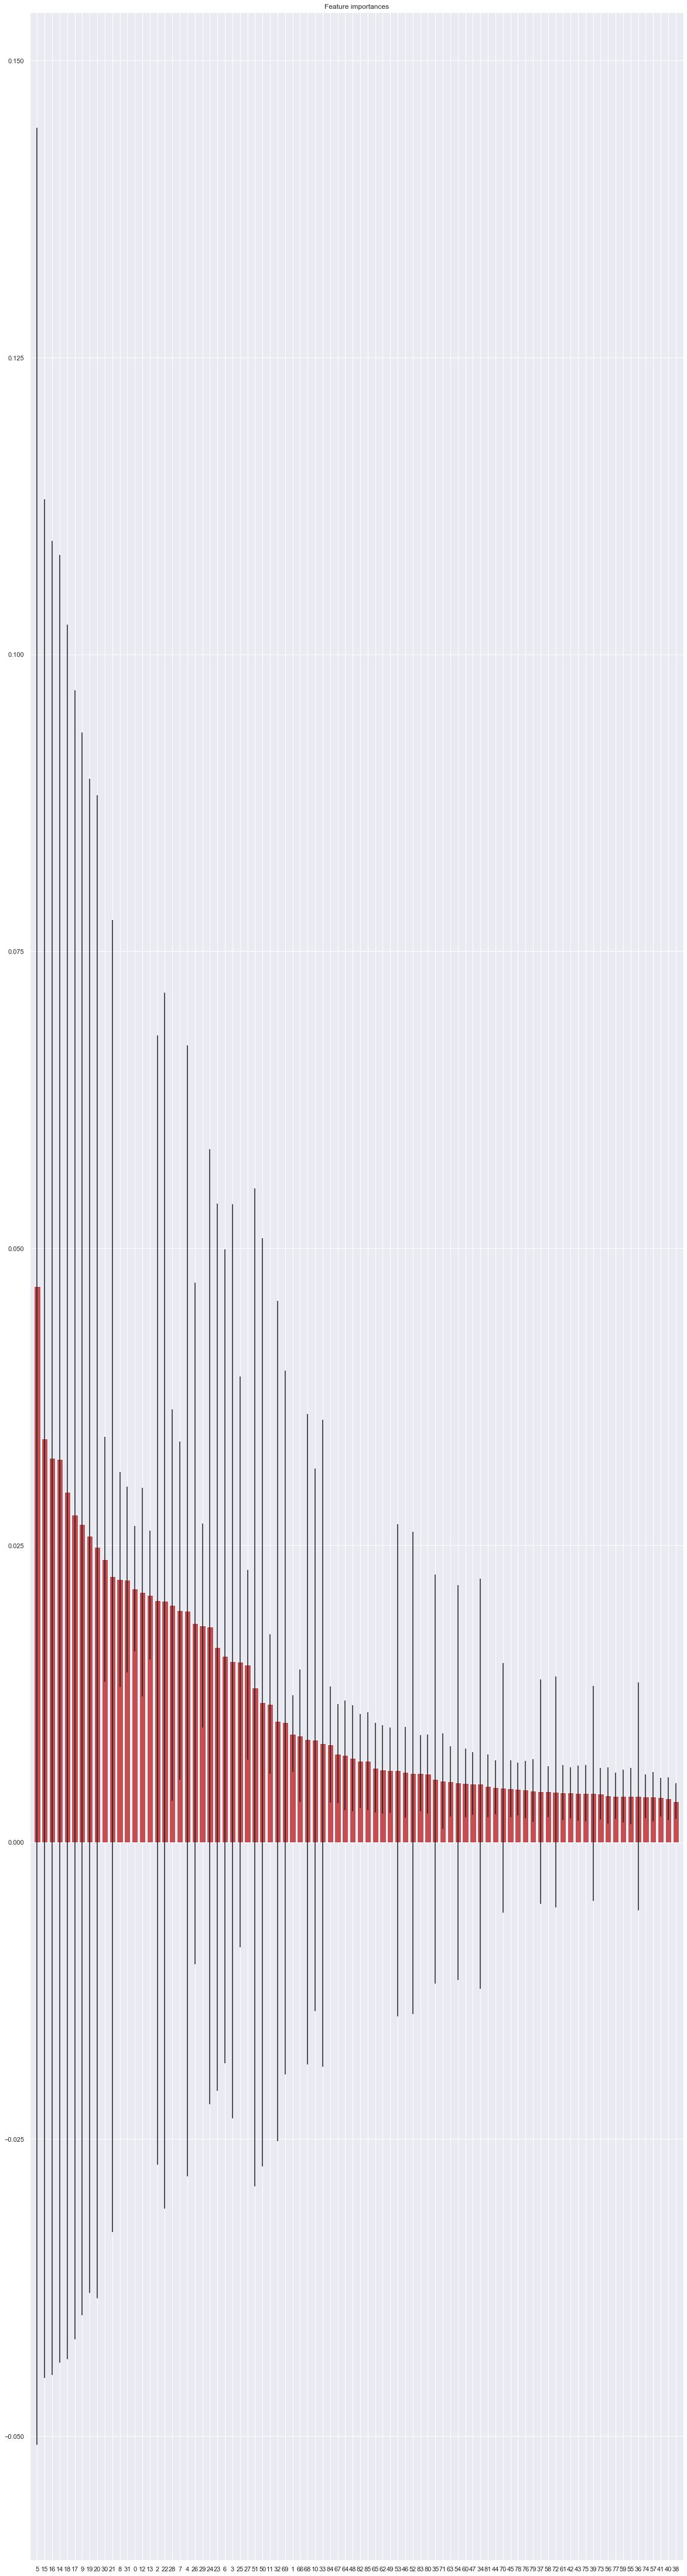

In [23]:
forest=model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [16]:
'''rf = RandomForestClassifier()
gs = GridSearchCV(rf,{ 'max_depth': np.arange(20,51,5),
                    'n_estimators':np.arange(400,1500,150),
                    'max_features':np.arange(0.39,0.91,0.05)}
                      ,verbose=2,n_jobs=-1, 
                        error_score='raise')

gs.fit(x_train,y_train.values.ravel())
gs.best_score_, gs.best_params_'''
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,6]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [17]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=644,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)